In [1]:
!pwd

/panda/eedy/iono-notebook


In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import h5py
import numpy as np
import os
import datetime as dt
import numpy as np
import math
from scipy import interpolate
from mintpy.objects import ionex, timeseries
from mintpy.simulation import iono
from mintpy.utils import readfile, writefile
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from mintpy import iono_tec
from mintpy.cli import diff, ifgram_inversion, modify_network, reference_point, reference_date
from mintpy.utils import utils as ut
from tqdm import trange
import h5py

from datetime import datetime
from netCDF4 import Dataset
from mintpy.utils import ptime, readfile, writefile


In [3]:
tframe_left = gpd.read_file("/home/eedy/data/aux/tframe_orbit/tframe_left_look.gpkg")
tframe_left.crs = "EPSG:4326"
# 初始化列表
ascending_frame_time_date = []
ascending_frame_time_utc_sec = []
ascending_NearLookAngle = []
ascending_FarLookAngle = []
ascending_lat1 = []
ascending_lon1 = []
ascending_lat2 = []
ascending_lon2 = []
ascending_lat3 = []
ascending_lon3 = []
ascending_lat4 = []
ascending_lon4 = []

descending_frame_time_date = []
descending_frame_time_utc_sec = []
descending_latitude = []
descending_longitude = []
descending_NearLookAngle = []
descending_FarLookAngle = []
descending_lat1 = []
descending_lon1 = []
descending_lat2 = []
descending_lon2 = []
descending_lat3 = []
descending_lon3 = []
descending_lat4 = []
descending_lon4 = []

# 遍历 track_frame
for index, row in tframe_left.iterrows():
    # 获取日期和时间
    startET = row['startET']
    endET = row['endET']
    tcenter = (startET + endET)/2.0
    import datetime
    frame_time_utc = datetime.datetime(2000,1,1)+datetime.timedelta(seconds=tcenter)
    frame_time_date = frame_time_utc.date()
    frame_time_utc_sec = frame_time_utc.hour * 60 + frame_time_utc.minute + frame_time_utc.second / 60

    # 获取入射角
    swathNearLookAngle = row['swathNearLookAngle']
    swathFarLookAngle = row['swathFarLookAngle']

    polygon = row['geometry']
    exterior_coords = polygon.geoms[0].exterior.coords
    # 提取四个角点
    corners = [exterior_coords[0], exterior_coords[len(exterior_coords) // 4],exterior_coords[len(exterior_coords) // 2], exterior_coords[3 * len(exterior_coords) // 4]]
    ## 1:右下  2:左下  3:左上  4:右上
    ## 1\4:FarLookAngle  2\3:NearLookAngle

    lat1 = corners[0][1]
    lon1 = corners[0][0]
    lat2 = corners[1][1]
    lon2 = corners[1][0]
    lat3 = corners[2][1]
    lon3 = corners[2][0]
    lat4 = corners[3][1]
    lon4 = corners[3][0]
    
    
    # 根据 passDirection 来决定是 ascending 还是 descending
    pass_direction = row['passDirection']
    
    if pass_direction == 'Ascending':
        ascending_frame_time_date.append(frame_time_date)
        ascending_frame_time_utc_sec.append(frame_time_utc_sec)
        ascending_NearLookAngle.append(swathNearLookAngle)
        ascending_FarLookAngle.append(swathFarLookAngle)
        ascending_lat1.append(lat1)
        ascending_lon1.append(lon1)
        ascending_lat2.append(lat2)
        ascending_lon2.append(lon2)
        ascending_lat3.append(lat3)
        ascending_lon3.append(lon3)
        ascending_lat4.append(lat4)
        ascending_lon4.append(lon4)
        
    elif pass_direction == 'Descending':
        descending_frame_time_date.append(frame_time_date)
        descending_frame_time_utc_sec.append(frame_time_utc_sec)
        descending_NearLookAngle.append(swathNearLookAngle)
        descending_FarLookAngle.append(swathFarLookAngle)
        descending_lat1.append(lat1)
        descending_lon1.append(lon1)
        descending_lat2.append(lat2)
        descending_lon2.append(lon2)
        descending_lat3.append(lat3)
        descending_lon3.append(lon3)
        descending_lat4.append(lat4)
        descending_lon4.append(lon4)
    else:
        # 处理其他情况，如果有的话
        pass


In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

# 定义一个函数来处理数据
def process_data(year_range, data_path_prefix):
    r_iono_all_1 = []
    r_iono_all_2 = []
    r_iono_all_3 = []
    r_iono_all_4 = []

    for year in year_range:
        # 打开.h5文件进行读取
        with h5py.File(f'{data_path_prefix}_{year}.h5', 'r') as h5f:
            # 读取数据集
            r_iono_1 = h5f['r_iono_1'][:]
            r_iono_2 = h5f['r_iono_2'][:]
            r_iono_3 = h5f['r_iono_3'][:]
            r_iono_4 = h5f['r_iono_4'][:]

        r_iono_means_1 = []
        r_iono_means_2 = []
        r_iono_means_3 = []
        r_iono_means_4 = []

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_1]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_1]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_1.append(mean_value)

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_2]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_2]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_2.append(mean_value)

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_3]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_3]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_3.append(mean_value)

        # 检查子列表长度是否相同
        lengths = [len(sublist) for sublist in r_iono_4]
        for index in range(len(r_iono_1[0])):
            # 收集每个子列表对应索引的元素
            values = [sublist[index] for sublist in r_iono_4]
            # 计算均值，忽略 np.nan
            mean_value = np.nanmean(values)
            r_iono_means_4.append(mean_value)

        r_iono_all_1.append(r_iono_means_1)
        r_iono_all_2.append(r_iono_means_2)
        r_iono_all_3.append(r_iono_means_3)
        r_iono_all_4.append(r_iono_means_4)

    # 计算每年变化的均值
    r_iono_all_1_array = np.array(r_iono_all_1)
    vel_r_iono_all_1_list = []
    for i in range(1, r_iono_all_1_array.shape[0]):
        vel_r_iono_all_1 = r_iono_all_1_array[i, :] - r_iono_all_1_array[i - 1, :]
        vel_r_iono_all_1_list.append(vel_r_iono_all_1)
    vel_r_iono_all_1_array = np.array(vel_r_iono_all_1_list)
    avg_r_iono_all_1 = np.mean(vel_r_iono_all_1_array, axis=0)

    r_iono_all_2_array = np.array(r_iono_all_2)
    vel_r_iono_all_2_list = []
    for i in range(1, r_iono_all_2_array.shape[0]):
        vel_r_iono_all_2 = r_iono_all_2_array[i, :] - r_iono_all_2_array[i - 1, :]
        vel_r_iono_all_2_list.append(vel_r_iono_all_2)
    vel_r_iono_all_2_array = np.array(vel_r_iono_all_2_list)
    avg_r_iono_all_2 = np.mean(vel_r_iono_all_2_array, axis=0)

    r_iono_all_3_array = np.array(r_iono_all_3)
    vel_r_iono_all_3_list = []
    for i in range(1, r_iono_all_3_array.shape[0]):
        vel_r_iono_all_3 = r_iono_all_3_array[i, :] - r_iono_all_3_array[i - 1, :]
        vel_r_iono_all_3_list.append(vel_r_iono_all_3)
    vel_r_iono_all_3_array = np.array(vel_r_iono_all_3_list)
    avg_r_iono_all_3 = np.mean(vel_r_iono_all_3_array, axis=0)

    r_iono_all_4_array = np.array(r_iono_all_4)
    vel_r_iono_all_4_list = []
    for i in range(1, r_iono_all_4_array.shape[0]):
        vel_r_iono_all_4 = r_iono_all_4_array[i, :] - r_iono_all_4_array[i - 1, :]
        vel_r_iono_all_4_list.append(vel_r_iono_all_4)
    vel_r_iono_all_4_array = np.array(vel_r_iono_all_4_list)
    avg_r_iono_all_4 = np.mean(vel_r_iono_all_4_array, axis=0)

    return avg_r_iono_all_1, avg_r_iono_all_2, avg_r_iono_all_3, avg_r_iono_all_4

# 定义一个函数来计算坡度和坡向
def calculate_slope(lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, avg1, avg2, avg3, avg4):
    n = len(lon1)
    dx = []
    dy = []
    center_lon = []
    center_lat = []

    for i in range(n):
        # 获取四个端点的经纬度和值
        lon1_i, lat1_i, z1 = lon1[i], lat1[i], avg1[i]
        lon2_i, lat2_i, z2 = lon2[i], lat2[i], avg2[i]
        lon3_i, lat3_i, z3 = lon3[i], lat3[i], avg3[i]
        lon4_i, lat4_i, z4 = lon4[i], lat4[i], avg4[i]

        # 计算中心点的经纬度
        center_loni = (lon1_i + lon2_i + lon3_i + lon4_i) / 4
        center_lati = (lat1_i + lat2_i + lat3_i + lat4_i) / 4

        # 计算坡度和坡向
        dz_dx = ((z2 - z1) + (z4 - z3)) / 2
        dz_dy = ((z3 - z2) + (z4 - z1)) / 2

        center_lon.append(center_loni)
        center_lat.append(center_lati)
        dx.append(dz_dx * 1000 / 2.5)
        dy.append(dz_dy * 1000 / 2.5)

    return dx, dy

# 处理上升数据
year_range = range(2014, 2020)
data_path_prefix_asc = 'data/high_global_a_12/asc_iono'
avg_r_iono_all_1_asc, avg_r_iono_all_2_asc, avg_r_iono_all_3_asc, avg_r_iono_all_4_asc = process_data(year_range, data_path_prefix_asc)
dx_asc, dy_asc = calculate_slope(ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, avg_r_iono_all_1_asc, avg_r_iono_all_2_asc, avg_r_iono_all_3_asc, avg_r_iono_all_4_asc)

# 处理下降数据
data_path_prefix_des = 'data/high_global_d_12/des_iono'
avg_r_iono_all_1_des, avg_r_iono_all_2_des, avg_r_iono_all_3_des, avg_r_iono_all_4_des = process_data(year_range, data_path_prefix_des)
dx_des, dy_des = calculate_slope(descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, avg_r_iono_all_1_des, avg_r_iono_all_2_des, avg_r_iono_all_3_des, avg_r_iono_all_4_des)

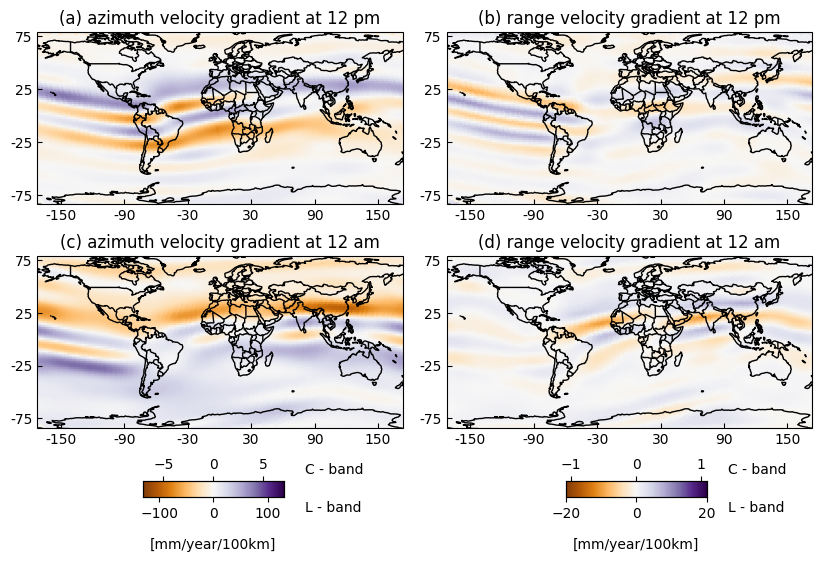

In [5]:
# 创建一个包含 2 行 2 列的网格布局（去掉颜色条行）
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)


# 定义一个函数来绘制子图
def plot_subplot(ax, lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, values, vmin, vmax, title):
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS)

    sc = ax.scatter(lon1, lat1, c=values, cmap='PuOr', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon2, lat2, c=values, cmap='PuOr', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon3, lat3, c=values, cmap='PuOr', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon4, lat4, c=values, cmap='PuOr', s=2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

    ax.set_extent([-172.5, 173.5, -84, 79], crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', direction='in')

    xticks = np.arange(-150, 151, 60)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks)

    yticks = np.arange(-75, 76, 50)
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_yticklabels(yticks)

    ax.set_title(title)
    return sc


# 绘制上升方位坡度图
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
plot_subplot(ax1, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, dy_asc, -130, 130, '(a) azimuth velocity gradient at 12 pm')

# 绘制上升距离坡度图
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
plot_subplot(ax2, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, dx_asc, -20, 20, '(b) range velocity gradient at 12 pm')

# 绘制下降方位坡度图
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
sc3 = plot_subplot(ax3, descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, dy_des, -130, 130, '(c) azimuth velocity gradient at 12 am')

# 绘制下降距离坡度图
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
sc4 = plot_subplot(ax4, descending_lon1, descending_lat1, descending_lon2, descending_lat2, descending_lon3, descending_lat3, descending_lon4, descending_lat4, dx_des, -20, 20, '(d) range velocity gradient at 12 am')

L = 1.257
C = 5.405
radio = L ** 2 / C ** 2

# 为第三个子图添加 colorbar
cax3 = fig.add_axes([ax3.get_position().x0 + 0.3 * ax3.get_position().width,
                     ax3.get_position().y0 - 0.02,  # 往上挪一些
                     0.4 * ax3.get_position().width,
                     0.02])
norm3 = plt.Normalize(vmin=-130, vmax=130)
sm3 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm3)
sm3.set_array(sc3.get_array())
cb3 = fig.colorbar(sm3, cax=cax3, orientation='horizontal')
sm3.set_clim(vmin=-130, vmax=130)
ax3_2 = cax3.twiny()
ax3_2.set_xlim(-130 * radio, 130 * radio)
cax3.text(1.15, -0.7, 'L - band', transform=cax3.transAxes, va='center')  # 文字往右挪一些
ax3_2.text(1.15, 1.7, 'C - band', transform=ax3_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax3.get_position().x0 + 0.5 * ax3.get_position().width, ax3.get_position().y0 - 0.08, '[mm/year/100km]',
         ha='center', va='center', fontsize=10)

# 为第四个子图添加 colorbar
cax4 = fig.add_axes([ax4.get_position().x0 + 0.3 * ax4.get_position().width,
                     ax4.get_position().y0 - 0.02,  # 往上挪一些
                     0.4 * ax4.get_position().width,
                     0.02])
norm4 = plt.Normalize(vmin=-20, vmax=20)
sm4 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm4)
sm4.set_array(sc4.get_array())
cb4 = fig.colorbar(sm4, cax=cax4, orientation='horizontal')
sm4.set_clim(vmin=-20, vmax=20)
ax4_2 = cax4.twiny()
ax4_2.set_xlim(-20 * radio, 20 * radio)
cax4.text(1.15, -0.7, 'L - band', transform=cax4.transAxes, va='center')  # 文字往右挪一些
ax4_2.text(1.15, 1.7, 'C - band', transform=ax4_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax4.get_position().x0 + 0.5 * ax4.get_position().width, ax4.get_position().y0 - 0.08, '[mm/year/100km]',
         ha='center', va='center', fontsize=10)

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.12, hspace=-0.43)
# 保存图像
#plt.savefig('pdf/global_iono.pdf', bbox_inches='tight', dpi=600, transparent=True)
# 显示图像
plt.show()

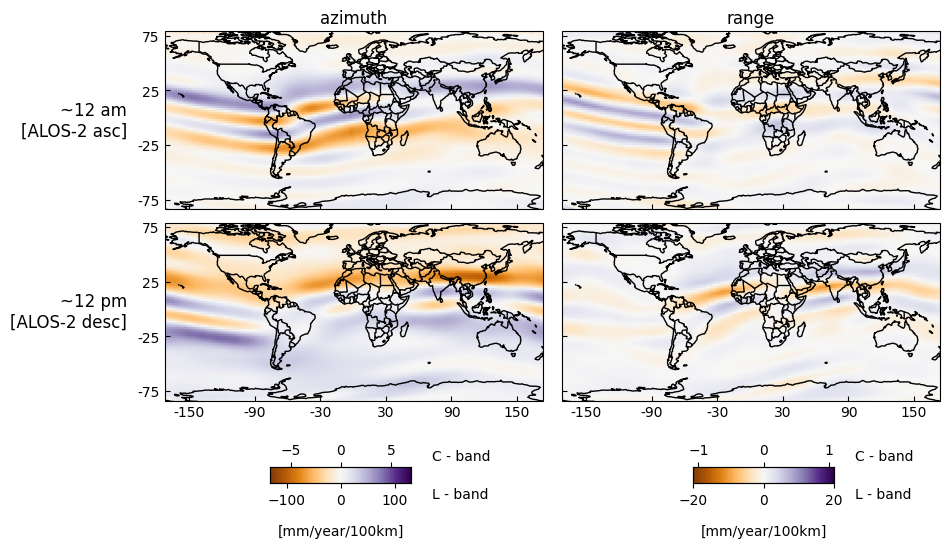

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建一个包含2行2列的网格布局
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)


# 定义一个函数来绘制子图
def plot_subplot(ax, lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, values, vmin, vmax, title, 
                 show_left_label=True, show_bottom_label=True):
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS)

    sc = ax.scatter(lon1, lat1, c=values, cmap='PuOr', s=1, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon2, lat2, c=values, cmap='PuOr', s=1, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon3, lat3, c=values, cmap='PuOr', s=1, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon4, lat4, c=values, cmap='PuOr', s=1, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

    ax.set_extent([-172.5, 173.5, -84, 79], crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', direction='in')

    xticks = np.arange(-150, 151, 60)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    # 控制是否显示底部坐标标签
    if show_bottom_label:
        ax.set_xticklabels(xticks)
    else:
        ax.set_xticklabels([])

    yticks = np.arange(-75, 76, 50)
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    # 控制是否显示左侧坐标标签
    if show_left_label:
        ax.set_yticklabels(yticks)
    else:
        ax.set_yticklabels([])

    ax.set_title(title)  # 标题为空时自动不显示
    return sc


# 绘制上升方位坡度图 - 第一行第一列，显示左侧标签，不显示底部标签
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
plot_subplot(ax1, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, 
             ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, 
             dy_asc, -130, 130, 'azimuth',  # 保留标题
             show_left_label=True, show_bottom_label=False)
# 添加6pm标签
ax1.text(-0.1, 0.5, '~12 am\n[ALOS-2 asc]', va='center', ha='right', rotation=0, multialignment='right',
     transform=ax1.transAxes, fontsize=12)

# 绘制上升距离坡度图 - 第一行第二列，不显示左侧标签，不显示底部标签
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
plot_subplot(ax2, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, 
             ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, 
             dx_asc, -20, 20, 'range',  # 保留标题
             show_left_label=False, show_bottom_label=False)

# 绘制下降方位坡度图 - 第二行第一列，显示左侧标签，显示底部标签
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
sc3 = plot_subplot(ax3, descending_lon1, descending_lat1, descending_lon2, descending_lat2, 
                   descending_lon3, descending_lat3, descending_lon4, descending_lat4, 
                   dy_des, -130, 130, '',  # 移除标题：设为空字符串
                   show_left_label=True, show_bottom_label=True)
# 添加6am标签
ax3.text(-0.1, 0.5, '~12 pm\n[ALOS-2 desc]', va='center', ha='right', rotation=0, multialignment='right',
         transform=ax3.transAxes, fontsize=12)

# 绘制下降距离坡度图 - 第二行第二列，不显示左侧标签，显示底部标签
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
sc4 = plot_subplot(ax4, descending_lon1, descending_lat1, descending_lon2, descending_lat2, 
                   descending_lon3, descending_lat3, descending_lon4, descending_lat4, 
                   dx_des, -20, 20, '',  # 移除标题：设为空字符串
                   show_left_label=False, show_bottom_label=True)

L = 1.257
C = 5.405
radio = L ** 2 / C ** 2

# 为第三个子图添加 colorbar
cax3 = fig.add_axes([ax3.get_position().x0 + 0.3 * ax3.get_position().width,
                     ax3.get_position().y0 - 0.02,  # 往上挪一些
                     0.4 * ax3.get_position().width,
                     0.02])
norm3 = plt.Normalize(vmin=-130, vmax=130)
sm3 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm3)
sm3.set_array(sc3.get_array())
cb3 = fig.colorbar(sm3, cax=cax3, orientation='horizontal')
sm3.set_clim(vmin=-130, vmax=130)
ax3_2 = cax3.twiny()
ax3_2.set_xlim(-130 * radio, 130 * radio)
cax3.text(1.15, -0.7, 'L - band', transform=cax3.transAxes, va='center')  # 文字往右挪一些
ax3_2.text(1.15, 1.7, 'C - band', transform=ax3_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax3.get_position().x0 + 0.5 * ax3.get_position().width, ax3.get_position().y0 - 0.08, '[mm/year/100km]',
         ha='center', va='center', fontsize=10)

# 为第四个子图添加 colorbar
cax4 = fig.add_axes([ax4.get_position().x0 + 0.3 * ax4.get_position().width,
                     ax4.get_position().y0 - 0.02,  # 往上挪一些
                     0.4 * ax4.get_position().width,
                     0.02])
norm4 = plt.Normalize(vmin=-20, vmax=20)
sm4 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm4)
sm4.set_array(sc4.get_array())
cb4 = fig.colorbar(sm4, cax=cax4, orientation='horizontal')
sm4.set_clim(vmin=-20, vmax=20)
ax4_2 = cax4.twiny()
ax4_2.set_xlim(-20 * radio, 20 * radio)
cax4.text(1.15, -0.7, 'L - band', transform=cax4.transAxes, va='center')  # 文字往右挪一些
ax4_2.text(1.15, 1.7, 'C - band', transform=ax4_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax4.get_position().x0 + 0.5 * ax4.get_position().width, ax4.get_position().y0 - 0.08, '[mm/year/100km]',
         ha='center', va='center', fontsize=10)

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.05, hspace=-0.55)
# 保存图像
plt.savefig('pic/global_iono_12.png', bbox_inches='tight', dpi=600, transparent=True)
# 显示图像
plt.show()

/tmp/ipykernel_188134/3953353446.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_yticks)
/tmp/ipykernel_188134/3953353446.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_yticks)


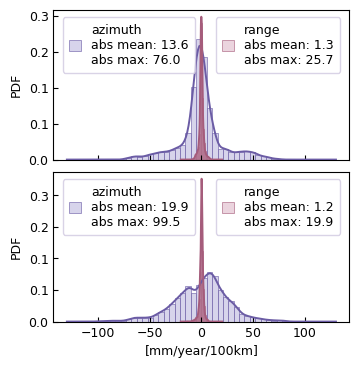

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import stats

# -------------------------- 1. 全局字体设置：统一为9号 --------------------------
plt.rcParams.update({
    'font.size': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'axes.titlesize': 9,
})


# -------------------------- 2. 2行1列网格布局 --------------------------
fig = plt.figure(figsize=(4, 4))  
gs = gridspec.GridSpec(
    nrows=2, ncols=1,
    height_ratios=[1, 1],
    hspace=0.08  # 维持紧凑上下间距
)


# -------------------------- 3. 统计图函数（修改图例部分） --------------------------
def plot_histogram(ax, dy_data, dx_data, dy_range, dx_range, hide_xaxis=False):
    # 1. 统计量计算（保留1位小数）
    dy_abs_mean = round(np.mean(np.abs(dy_data)), 1)
    dy_abs_max = round(np.max(np.abs(dy_data)), 1)
    dx_abs_mean = round(np.mean(np.abs(dx_data)), 1)
    dx_abs_max = round(np.max(np.abs(dx_data)), 1)
    
    # 2. PDF归一化样本数
    total_dy = len(dy_data)
    total_dx = len(dx_data)
    total = max(total_dy, total_dx)
    
    # 3. 紫色直方图（添加label参数用于图例）
    n_bins_dy = 50
    hist_dy, bins_dy, patches_dy = ax.hist(
        dy_data, bins=n_bins_dy, range=dy_range, 
        color='#c7c3e3', edgecolor='#6b5ca5', linewidth=0.6,
        alpha=0.7, label=f'azimuth\nabs mean: {dy_abs_mean:.1f}\nabs max: {dy_abs_max:.1f}'
    )
    
    # 粉色直方图（添加label参数用于图例）
    n_bins_dx = 50
    hist_dx, bins_dx, patches_dx = ax.hist(
        dx_data, bins=n_bins_dx, range=dx_range, 
        color='#e3c3d1', edgecolor='#a55c7b', linewidth=0.6,
        alpha=0.7, label=f'range\nabs mean: {dx_abs_mean:.1f}\nabs max: {dx_abs_max:.1f}'
    )
    
    # 4. 平滑曲线
    # 方位梯度（dy）曲线
    x_dy = np.linspace(dy_range[0], dy_range[1], 200)
    kde_dy = stats.gaussian_kde(dy_data)
    bin_width_dy = (dy_range[1] - dy_range[0]) / n_bins_dy
    line_dy, = ax.plot(x_dy, kde_dy(x_dy) * total * bin_width_dy, 
            color='#6b5ca5', linewidth=1.4, zorder=5)
    
    # 距离梯度（dx）曲线
    x_dx = np.linspace(dx_range[0], dx_range[1], 200)
    kde_dx = stats.gaussian_kde(dx_data)
    bin_width_dx = (dx_range[1] - dx_range[0]) / n_bins_dx
    line_dx, = ax.plot(x_dx, kde_dx(x_dx) * total * bin_width_dx, 
            color='#a55c7b', linewidth=1.4, zorder=5)
    
    # 5. 轴样式
    ax.tick_params(axis='both', direction='in')
    if hide_xaxis:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('[mm/year/100km]', labelpad=4)
    
    # 6. Y轴标签
    ax.set_ylabel('PDF', labelpad=4)
    
    # 7. 分离的图例 - 分别放置在左上角和右上角
    # 紫色数据（azimuth）的图例放在左上角
    legend1 = ax.legend(
        [patches_dy[0], line_dy],  # 使用第一个直方图补丁和曲线作为图例项
        [f'azimuth\nabs mean: {dy_abs_mean:.1f}\nabs max: {dy_abs_max:.1f}'],
        loc='upper left', bbox_to_anchor=(0.01, 0.99),
        frameon=True, framealpha=0.8, edgecolor='#d0c8e0',
        handlelength=1.0, handleheight=1.0, borderpad=0.5,
        labelspacing=0.3
    )
    ax.add_artist(legend1)  # 添加第一个图例
    
    # 粉色数据（range）的图例放在右上角
    ax.legend(
        [patches_dx[0], line_dx],  # 使用第一个直方图补丁和曲线作为图例项
        [f'range\nabs mean: {dx_abs_mean:.1f}\nabs max: {dx_abs_max:.1f}'],
        loc='upper right', bbox_to_anchor=(0.99, 0.99),
        frameon=True, framealpha=0.8, edgecolor='#d0c8e0',
        handlelength=1.0, handleheight=1.0, borderpad=0.5,
        labelspacing=0.3
    )
    
    ax.grid(False)
    
    # 8. Y轴PDF刻度
    yticks = ax.get_yticks()
    new_yticks = [f'{round(ytick / total, 1):.1f}' for ytick in yticks if ytick >= 0]
    ax.set_yticklabels(new_yticks)

# -------------------------- 5. 绘制子图 --------------------------
# 上行子图（12pm）：隐藏X轴
ax_hist1 = plt.subplot(gs[0, 0])
plot_histogram(
    ax=ax_hist1, dy_data=dy_asc, dx_data=dx_asc,
    dy_range=(-130, 130), dx_range=(-20, 20),
    hide_xaxis=True
)

# 下行子图（12am）：保留X轴
ax_hist2 = plt.subplot(gs[1, 0])
plot_histogram(
    ax=ax_hist2, dy_data=dy_des, dx_data=dx_des,
    dy_range=(-130, 130), dx_range=(-20, 20),
    hide_xaxis=False
)


# -------------------------- 6. 布局微调 --------------------------
plt.subplots_adjust(
    left=0.21,
    right=0.95,
    top=0.93,
    bottom=0.15
)

# 保存与显示
plt.savefig('pic/global_iono_hist_12.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

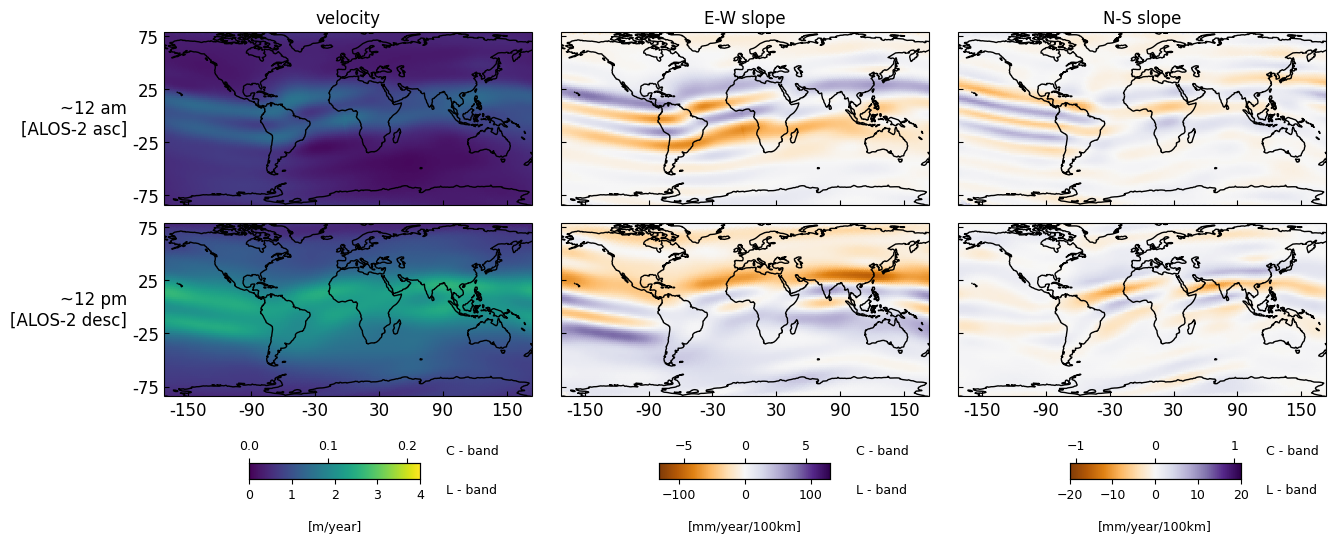

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建图形和网格布局
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3)

# 绘图函数定义（统一字体为12号）
def plot_subplot(ax, lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, values, 
                 vmin, vmax, cmap, title, show_left_label=True, show_bottom_label=True):
    # 仅添加海岸线，不添加国界
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    
    # 绘制散点
    sc = ax.scatter(lon1, lat1, c=values, cmap=cmap, s=1, alpha=1, 
                   transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon2, lat2, c=values, cmap=cmap, s=1, alpha=1, 
               transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon3, lat3, c=values, cmap=cmap, s=1, alpha=1, 
               transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon4, lat4, c=values, cmap=cmap, s=1, alpha=1, 
               transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

    # 设置地图范围和刻度（刻度标签字体12号）
    ax.set_extent([-172.5, 173.5, -84, 79], crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', direction='in', labelsize=12)  # 刻度标签字体12号

    xticks = np.arange(-150, 151, 60)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks if show_bottom_label else [], fontsize=12)  # 显式设置12号

    yticks = np.arange(-75, 76, 50)
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_yticklabels(yticks if show_left_label else [], fontsize=12)  # 显式设置12号

    # 子图标题字体12号
    ax.set_title(title, fontsize=12)
    return sc


# ---------------------- 第一列：速度图 ----------------------
# 上行速度图（第一行第一列）
ax5 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
plot_subplot(ax=ax5,
             lon1=ascending_lon1, lat1=ascending_lat1,
             lon2=ascending_lon2, lat2=ascending_lat2,
             lon3=ascending_lon3, lat3=ascending_lat3,
             lon4=ascending_lon4, lat4=ascending_lat4,
             values=-avg_r_iono_all_1_asc, vmin=0, vmax=4,
             cmap='viridis', title='velocity',
             show_left_label=True, show_bottom_label=False)
# 侧边文本注释字体12号（保持原设置，此处原本已是12号，统一确认）
ax5.text(-0.1, 0.5, '~12 am\n[ALOS-2 asc]', 
         va='center', ha='right', rotation=0, multialignment='right',
         transform=ax5.transAxes, fontsize=12)

# 下行速度图（第二行第一列）- 无标题
ax6 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
sc6 = plot_subplot(ax=ax6,
                   lon1=descending_lon1, lat1=descending_lat1,
                   lon2=descending_lon2, lat2=descending_lat2,
                   lon3=descending_lon3, lat3=descending_lat3,
                   lon4=descending_lon4, lat4=descending_lat4,
                   values=-avg_r_iono_all_1_des, vmin=0, vmax=4,
                   cmap='viridis', title='',  # 下方子图无标题
                   show_left_label=True, show_bottom_label=True)
# 侧边文本注释字体12号
ax6.text(-0.1, 0.5, '~12 pm\n[ALOS-2 desc]', 
         va='center', ha='right', rotation=0, multialignment='right',
         transform=ax6.transAxes, fontsize=12)


# ---------------------- 第二列：方位坡度图 ----------------------
# 上行方位坡度图（第一行第二列）
ax1 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
plot_subplot(ax=ax1, 
             lon1=ascending_lon1, lat1=ascending_lat1, 
             lon2=ascending_lon2, lat2=ascending_lat2, 
             lon3=ascending_lon3, lat3=ascending_lat3, 
             lon4=ascending_lon4, lat4=ascending_lat4, 
             values=dy_asc, vmin=-130, vmax=130, 
             cmap='PuOr', title='E-W slope',
             show_left_label=False, show_bottom_label=False)

# 下行方位坡度图（第二行第二列）- 无标题
ax3 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
sc3 = plot_subplot(ax=ax3,
                   lon1=descending_lon1, lat1=descending_lat1,
                   lon2=descending_lon2, lat2=descending_lat2,
                   lon3=descending_lon3, lat3=descending_lat3,
                   lon4=descending_lon4, lat4=descending_lat4,
                   values=dy_des, vmin=-130, vmax=130,
                   cmap='PuOr', title='',  # 下方子图无标题
                   show_left_label=False, show_bottom_label=True)


# ---------------------- 第三列：距离坡度图 ----------------------
# 上行距离坡度图（第一行第三列）
ax2 = plt.subplot(gs[0, 2], projection=ccrs.PlateCarree())
plot_subplot(ax=ax2,
             lon1=ascending_lon1, lat1=ascending_lat1,
             lon2=ascending_lon2, lat2=ascending_lat2,
             lon3=ascending_lon3, lat3=ascending_lat3,
             lon4=ascending_lon4, lat4=ascending_lat4,
             values=dx_asc, vmin=-20, vmax=20,
             cmap='PuOr', title='N-S slope',
             show_left_label=False, show_bottom_label=False)

# 下行距离坡度图（第二行第三列）- 无标题
ax4 = plt.subplot(gs[1, 2], projection=ccrs.PlateCarree())
sc4 = plot_subplot(ax=ax4,
                   lon1=descending_lon1, lat1=descending_lat1,
                   lon2=descending_lon2, lat2=descending_lat2,
                   lon3=descending_lon3, lat3=descending_lat3,
                   lon4=descending_lon4, lat4=descending_lat4,
                   values=dx_des, vmin=-20, vmax=20,
                   cmap='PuOr', title='',  # 下方子图无标题
                   show_left_label=False, show_bottom_label=True)


# 波段转换系数
L = 1.257
C = 5.405
radio = L ** 2 / C ** 2


# ---------------------- 颜色条（缩短长度，字体统一12号） ----------------------
# 第一列颜色条（速度图）
cax6 = fig.add_axes([ax6.get_position().x0 + 0.25 * ax6.get_position().width,
                     ax6.get_position().y0 - 0.02,
                     0.5 * ax6.get_position().width,  # 缩短长度
                     0.02])
norm6 = plt.Normalize(vmin=0, vmax=4)
sm6 = plt.cm.ScalarMappable(cmap='viridis', norm=norm6)
sm6.set_array(sc6.get_array())
cb6 = fig.colorbar(sm6, cax=cax6, orientation='horizontal')
sm6.set_clim(vmin=0, vmax=4)
# 颜色条刻度标签12号
ax6_2 = cax6.twiny()
ax6_2.set_xlim(0 * radio, 4 * radio)
# 颜色条侧边文本12号
cax6.text(1.15, -0.7, 'L - band', transform=cax6.transAxes, va='center')
ax6_2.text(1.15, 1.7, 'C - band', transform=ax6_2.transAxes, va='center')
# 颜色条单位标签12号
fig.text(ax6.get_position().x0 + 0.5 * ax6.get_position().width, 
         ax6.get_position().y0 - 0.08, '[m/year]', 
         ha='center', va='center')

# 第二列颜色条（方位坡度图）
cax3 = fig.add_axes([ax3.get_position().x0 + 0.25 * ax3.get_position().width,
                     ax3.get_position().y0 - 0.02,
                     0.5 * ax3.get_position().width,  # 缩短长度
                     0.02])
norm3 = plt.Normalize(vmin=-130, vmax=130)
sm3 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm3)
sm3.set_array(sc3.get_array())
cb3 = fig.colorbar(sm3, cax=cax3, orientation='horizontal')
sm3.set_clim(vmin=-130, vmax=130)
# 颜色条刻度标签12号
ax3_2 = cax3.twiny()
ax3_2.set_xlim(-130 * radio, 130 * radio)
# 颜色条侧边文本12号
cax3.text(1.15, -0.7, 'L - band', transform=cax3.transAxes, va='center')
ax3_2.text(1.15, 1.7, 'C - band', transform=ax3_2.transAxes, va='center')
# 颜色条单位标签12号
fig.text(ax3.get_position().x0 + 0.5 * ax3.get_position().width, 
         ax3.get_position().y0 - 0.08, '[mm/year/100km]', 
         ha='center', va='center')

# 第三列颜色条（距离坡度图）
cax4 = fig.add_axes([ax4.get_position().x0 + 0.25 * ax4.get_position().width,
                     ax4.get_position().y0 - 0.02,
                     0.5 * ax4.get_position().width,  # 缩短长度
                     0.02])
norm4 = plt.Normalize(vmin=-20, vmax=20)
sm4 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm4)
sm4.set_array(sc4.get_array())
cb4 = fig.colorbar(sm4, cax=cax4, orientation='horizontal')
sm4.set_clim(vmin=-20, vmax=20)
# 颜色条刻度标签12号
ax4_2 = cax4.twiny()
ax4_2.set_xlim(-20 * radio, 20 * radio)
# 颜色条侧边文本12号
cax4.text(1.15, -0.7, 'L - band', transform=cax4.transAxes, va='center')
ax4_2.text(1.15, 1.7, 'C - band', transform=ax4_2.transAxes, va='center')
# 颜色条单位标签12号
fig.text(ax4.get_position().x0 + 0.5 * ax4.get_position().width, 
         ax4.get_position().y0 - 0.08, '[mm/year/100km]', 
         ha='center', va='center')


# 调整布局间距
plt.subplots_adjust(wspace=0.08, hspace=-0.55)

# 保存和显示
plt.savefig('pic/global_iono_12.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

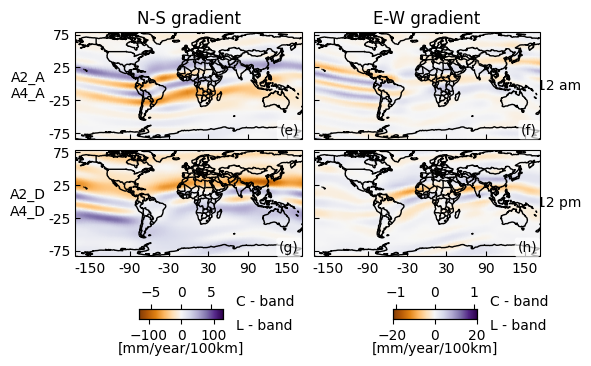

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建一个包含2行2列的网格布局
fig = plt.figure(figsize=(6, 5))
gs = gridspec.GridSpec(2, 2)


# 定义一个函数来绘制子图
def plot_subplot(ax, lon1, lat1, lon2, lat2, lon3, lat3, lon4, lat4, values, vmin, vmax, title, 
                 show_left_label=True, show_bottom_label=True):
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS)

    sc = ax.scatter(lon1, lat1, c=values, cmap='PuOr', s=0.2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon2, lat2, c=values, cmap='PuOr', s=0.2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon3, lat3, c=values, cmap='PuOr', s=0.2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.scatter(lon4, lat4, c=values, cmap='PuOr', s=0.2, alpha=1, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

    ax.set_extent([-172.5, 173.5, -84, 79], crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', direction='in')

    xticks = np.arange(-150, 151, 60)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    # 控制是否显示底部坐标标签
    if show_bottom_label:
        ax.set_xticklabels(xticks)
    else:
        ax.set_xticklabels([])

    yticks = np.arange(-75, 76, 50)
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    # 控制是否显示左侧坐标标签
    if show_left_label:
        ax.set_yticklabels(yticks)
    else:
        ax.set_yticklabels([])

    ax.set_title(title)  # 标题为空时自动不显示
    return sc


# -------------------------- 第一行左：标注 (a) （下移+右移+浅白背景） --------------------------
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
plot_subplot(ax1, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, 
             ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, 
             dy_asc, -130, 130, 'N-S gradient',  # 保留标题
             show_left_label=True, show_bottom_label=False)
# 添加6pm标签
ax1.text(2.23, 0.5, '12 am', va='center', ha='right', rotation=0, multialignment='right',
     transform=ax1.transAxes)
ax1.text(-0.13, 0.5, 'A2_A\nA4_A', va='center', ha='right', rotation=0, multialignment='right',
     transform=ax1.transAxes)
# 标注(a)：x从0.95→0.98（右移），y从0.03→0.01（下移）；bbox设浅白色(white)、半透明(alpha=0.7)、无框线
ax1.text(0.985, 0.02, '(e)', va='bottom', ha='right', transform=ax1.transAxes,
         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))


# -------------------------- 第一行右：标注 (b) （同步调整+浅白背景） --------------------------
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
plot_subplot(ax2, ascending_lon1, ascending_lat1, ascending_lon2, ascending_lat2, 
             ascending_lon3, ascending_lat3, ascending_lon4, ascending_lat4, 
             dx_asc, -20, 20, 'E-W gradient',  # 保留标题
             show_left_label=False, show_bottom_label=False)
# 标注(b)：与(a)位置同步，背景参数一致
ax2.text(0.985, 0.02, '(f)', va='bottom', ha='right', transform=ax2.transAxes,
         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))


# -------------------------- 第二行左：标注 (c) （同步调整+浅白背景） --------------------------
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
sc3 = plot_subplot(ax3, descending_lon1, descending_lat1, descending_lon2, descending_lat2, 
                   descending_lon3, descending_lat3, descending_lon4, descending_lat4, 
                   dy_des, -130, 130, '',  # 移除标题：设为空字符串
                   show_left_label=True, show_bottom_label=True)
# 添加6am标签
ax3.text(2.23, 0.5, '12 pm', va='center', ha='right', rotation=0, multialignment='right',
         transform=ax3.transAxes)
ax3.text(-0.13, 0.5, 'A2_D\nA4_D', va='center', ha='right', rotation=0, multialignment='right',
         transform=ax3.transAxes)
# 标注(c)：位置与(a)对称，背景参数一致
ax3.text(0.985, 0.02, '(g)', va='bottom', ha='right', transform=ax3.transAxes,
         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))


# -------------------------- 第二行右：标注 (d) （同步调整+浅白背景） --------------------------
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
sc4 = plot_subplot(ax4, descending_lon1, descending_lat1, descending_lon2, descending_lat2, 
                   descending_lon3, descending_lat3, descending_lon4, descending_lat4, 
                   dx_des, -20, 20, '',  # 移除标题：设为空字符串
                   show_left_label=False, show_bottom_label=True)
# 标注(d)：位置与其他标注统一，背景参数一致
ax4.text(0.985, 0.02, '(h)', va='bottom', ha='right', transform=ax4.transAxes,
         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))


L = 1.257
C = 5.405
radio = L ** 2 / C ** 2

# 为第三个子图添加 colorbar（原逻辑不变）
cax3 = fig.add_axes([ax3.get_position().x0 + 0.3 * ax3.get_position().width,
                     ax3.get_position().y0 - 0.04,  # 往上挪一些
                     0.4 * ax3.get_position().width,
                     0.02])
norm3 = plt.Normalize(vmin=-130, vmax=130)
sm3 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm3)
sm3.set_array(sc3.get_array())
cb3 = fig.colorbar(sm3, cax=cax3, orientation='horizontal')
sm3.set_clim(vmin=-130, vmax=130)
ax3_2 = cax3.twiny()
ax3_2.set_xlim(-130 * radio, 130 * radio)
cax3.text(1.15, -0.7, 'L - band', transform=cax3.transAxes, va='center')  # 文字往右挪一些
ax3_2.text(1.15, 1.7, 'C - band', transform=ax3_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax3.get_position().x0 + 0.5 * ax3.get_position().width, ax3.get_position().y0 - 0.10, '[mm/year/100km]',
         ha='center', va='center')

# 为第四个子图添加 colorbar（原逻辑不变）
cax4 = fig.add_axes([ax4.get_position().x0 + 0.3 * ax4.get_position().width,
                     ax4.get_position().y0 - 0.04,  # 往上挪一些
                     0.4 * ax4.get_position().width,
                     0.02])
norm4 = plt.Normalize(vmin=-20, vmax=20)
sm4 = plt.cm.ScalarMappable(cmap='PuOr', norm=norm4)
sm4.set_array(sc4.get_array())
cb4 = fig.colorbar(sm4, cax=cax4, orientation='horizontal')
sm4.set_clim(vmin=-20, vmax=20)
ax4_2 = cax4.twiny()
ax4_2.set_xlim(-20 * radio, 20 * radio)
cax4.text(1.15, -0.7, 'L - band', transform=cax4.transAxes, va='center')  # 文字往右挪一些
ax4_2.text(1.15, 1.7, 'C - band', transform=ax4_2.transAxes, va='center')  # 文字往右挪一些
fig.text(ax4.get_position().x0 + 0.5 * ax4.get_position().width, ax4.get_position().y0 - 0.10, '[mm/year/100km]',
         ha='center', va='center')

# 调整子图之间的间距（原参数不变）
plt.subplots_adjust(wspace=0.05, hspace=-0.56)
# 保存图像
plt.savefig('pic/global_iono_12.png', bbox_inches='tight', dpi=600, transparent=True)
# 显示图像
plt.show()